# PREDICTING GENDER OF MONK SEALS 

Predicting a categorical target variable (gender) using continuous feature variables (blood chemistry values), then compare
two models: one with mass as a feature and one without mass

## Import Packages and Read In Data

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tpot import TPOTClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

C:\Users\alica\anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
seal_df = pd.read_csv('MonkSeal.csv')

## Explore Data

In [3]:
print(seal_df.head())
print(seal_df.describe())
print(seal_df.info())
nRow, nCol = seal_df.shape
print(f'There are {nRow} rows and {nCol} columns')

    UID  ID_Recap stock               site  DOY       Date  month  day  year  \
0  5151       NaN  west  AGATTU/CAPE SABAK  175  6/24/1998      6   24  1998   
1  5155       NaN  west  AGATTU/CAPE SABAK  175  6/24/1998      6   24  1998   
2  5158       NaN  west  AGATTU/CAPE SABAK  175  6/24/1998      6   24  1998   
3  5170       NaN  west  AGATTU/CAPE SABAK  175  6/24/1998      6   24  1998   
4  5173       NaN  west  AGATTU/CAPE SABAK  175  6/24/1998      6   24  1998   

  adjsex  ... ABS_Eos  ABS_Bands  ABS_Polys  ABS_Lymphs  ABS_Monos  Adj_Tot  \
0      M  ...   696.0        0.0     5220.0      2610.0       87.0   8700.0   
1      M  ...     NaN        NaN        NaN         NaN        NaN      NaN   
2      F  ...   192.0        0.0     6912.0      2304.0      192.0   9600.0   
3      M  ...     NaN        NaN        NaN         NaN        NaN      NaN   
4      M  ...     NaN        NaN        NaN         NaN        NaN      NaN   

   lipemic  NRBC            Phoenix_Comments

## Removing Unneccessary Columns

In [4]:
# Delete columns
seal_df.drop(['UID', 'ID_Recap', 'stock', 'site','DOY', 'Date', 'month', 'day', 'year', 'age',
              'Phoenix_ID_Diff', 'Plates_comments', 'Plates_clumped', 'lipemic', 'Phoenix_Comments',
              'hemolysis', 'Adj_Tot'], axis=1, inplace=True)
print(seal_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   adjsex      1015 non-null   object 
 1   mass        996 non-null    float64
 2   Ave_Hct     854 non-null    float64
 3   RBC         748 non-null    float64
 4   WBC         870 non-null    float64
 5   MCV         602 non-null    float64
 6   Hb          256 non-null    float64
 7   MCH         11 non-null     float64
 8   MCHC        214 non-null    float64
 9   ABS_Baso    897 non-null    float64
 10  ABS_Eos     897 non-null    float64
 11  ABS_Bands   897 non-null    float64
 12  ABS_Polys   897 non-null    float64
 13  ABS_Lymphs  897 non-null    float64
 14  ABS_Monos   897 non-null    float64
 15  NRBC        441 non-null    float64
dtypes: float64(15), object(1)
memory usage: 127.0+ KB
None


## Encode and Divide Data Into Features and Target

In [5]:
# Encode taget variable as numeric
# Fitting The label encoder
le = preprocessing.LabelEncoder()

# Fitting the encoder to the target column
le.fit(seal_df['adjsex'])

# Viewing the targets
print(); print(list(le.classes_))

# Transform categories into integers
seal_df['target'] = le.transform(seal_df['adjsex'])

# Apply the fitted encoder to the target column
print(); print(seal_df['target'])


['F', 'M']

0       1
1       1
2       0
3       1
4       1
       ..
1010    1
1011    0
1012    0
1013    0
1014    1
Name: target, Length: 1015, dtype: int32


Females are now coded as 0 and males are 1

In [6]:
# Separate into features and target
X=seal_df.drop(["adjsex", "target"],axis=1)
y=seal_df.target

## Clean Data

mass            19
Ave_Hct        161
RBC            267
WBC            145
MCV            413
Hb             759
MCH           1004
MCHC           801
ABS_Baso       118
ABS_Eos        118
ABS_Bands      118
ABS_Polys      118
ABS_Lymphs     118
ABS_Monos      118
NRBC           574
dtype: int64


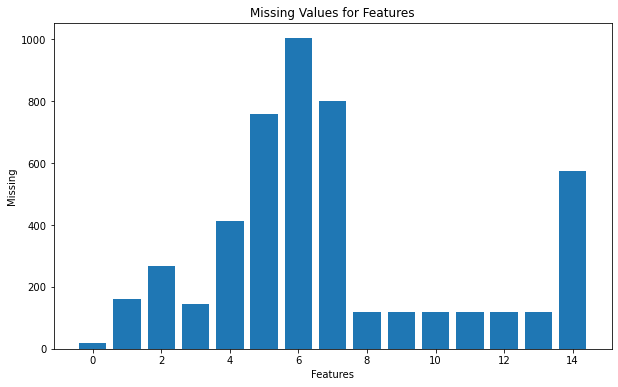

In [7]:
# Check for null values in features and plot
null=X.isnull().sum()
print(null)
plt.figure(figsize=(10,6))
plt.bar(range(len(null)), null)
plt.title('Missing Values for Features')
plt.xlabel('Features')
plt.ylabel('Missing')
plt.show()

In [8]:
# Removing columns with more than 50% NAN values and replacing NAN values of rest with median or mode
for col in X.columns.values:
    
    if (pd.isna(X[col]).sum()) > 0: 
    
        if pd.isna(X[col]).sum() > (50/100 * len(X)): 
            print(col,"removed") 
            X = X.drop([col], axis=1) 
        
        elif (X[col].dtype == 'object'):
            X[col] = X[col].fillna(X[col].mode()[0])        
        
        else:
            X[col] = X[col].fillna(X[col].median())
            
                
print(X.shape)
print(X.isna().sum())

Hb removed
MCH removed
MCHC removed
NRBC removed
(1015, 11)
mass          0
Ave_Hct       0
RBC           0
WBC           0
MCV           0
ABS_Baso      0
ABS_Eos       0
ABS_Bands     0
ABS_Polys     0
ABS_Lymphs    0
ABS_Monos     0
dtype: int64


## EDA

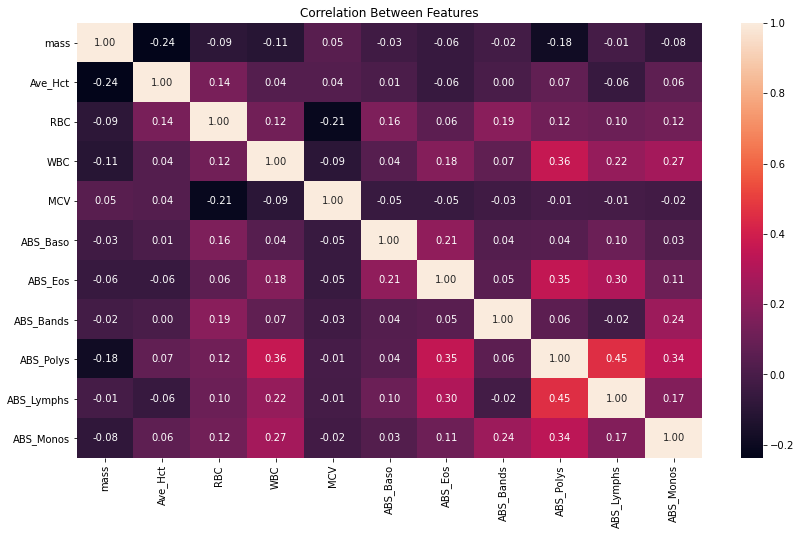

In [9]:
# Check for correlations between features
corr =X.corr()
fig, ax =plt.subplots(figsize =(14,8))
ax  = sns.heatmap(corr,annot =True,fmt = ".2f")
ax.set_title('Correlation Between Features');

In [10]:
# Checking correlations between features and target
corr_values = X.corrwith(y)
print("Correlation between features")
print(abs(corr_values).sort_values(ascending=False))

Correlation between features
mass          0.439795
WBC           0.066716
ABS_Eos       0.049356
ABS_Bands     0.029805
ABS_Baso      0.015067
MCV           0.013157
ABS_Monos     0.012618
ABS_Lymphs    0.011091
ABS_Polys     0.007421
Ave_Hct       0.006938
RBC           0.005324
dtype: float64


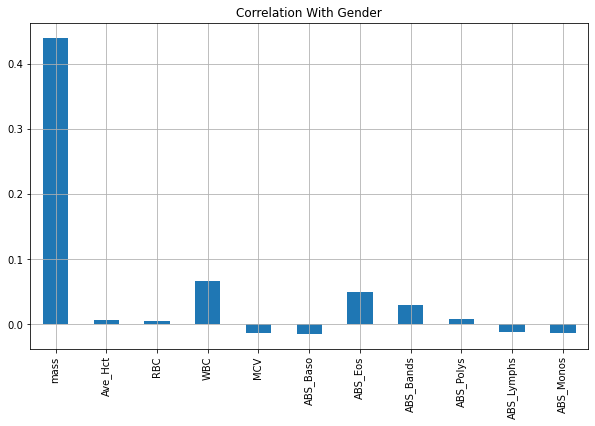

In [11]:
# Plot correlations between features and target
X.corrwith(y).plot(kind='bar',
                           grid=True, 
                           figsize=(10, 6),
                           title="Correlation With Gender");

Mass is obviously correlated with gender, however the correlation value is less than 0.5, so I will keep it
in the model for now. It might be interesting to see how poorly the model functions when this feature
is dropped.

## Split Data Into Train and Test

In [12]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                y,test_size=0.2,
                                random_state=68)

## Checking Balance of Dataset Before Training Classifier


In [13]:
# Count the classifing values
y.value_counts()

1    538
0    477
Name: target, dtype: int64

## Standardizing Data

In [14]:
# Standardize data to better fit regression
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

## Regression Model To Evaluate First

In [15]:
# Instantiate logistic regression 
logreg = LogisticRegression()

# Fit logreg to the train set
logreg.fit(X_train,y_train)

# Predict instances from the test set
y_pred = logreg.predict(X_test)

# Accuracy score of logreg model
print("Accuracy of logistic regression: ", logreg.score(X_test,y_test))

# Confusion matrix of the logreg model
print('Confusion matrix:\n ', confusion_matrix(y_test,y_pred))

Accuracy of logistic regression:  0.6847290640394089
Confusion matrix:
  [[56 30]
 [34 83]]


Looks like a useable model, although not great. Is there a better one?

## Set up TPOT Classifier

In [16]:
# Instantiate TPOTClassifier
tpot = TPOTClassifier(
    generations=10,
    population_size=20,
    verbosity=2,
    scoring='roc_auc',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)
tpot.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.7754040941271023

Generation 2 - Current best internal CV score: 0.7757366283092268

Generation 3 - Current best internal CV score: 0.7757366283092268

Generation 4 - Current best internal CV score: 0.7764387994730513

Generation 5 - Current best internal CV score: 0.7808330537667842

Generation 6 - Current best internal CV score: 0.7808330537667842

Generation 7 - Current best internal CV score: 0.7809621680544987

Generation 8 - Current best internal CV score: 0.7809621680544987

Generation 9 - Current best internal CV score: 0.7809621680544987

Generation 10 - Current best internal CV score: 0.7809621680544987

Best pipeline: KNeighborsClassifier(MinMaxScaler(input_matrix), n_neighbors=79, p=2, weights=distance)


TPOTClassifier(config_dict='TPOT light', disable_update_check=True,
               generations=10, population_size=20, random_state=42,
               scoring='roc_auc', verbosity=2)

In [17]:
# AUC score for tpot model
tpot_auc_score = roc_auc_score(y_test, tpot.predict_proba(X_test)[:, 1])
print(f'\nROC_AUC score: {tpot_auc_score:.4f}')


ROC_AUC score: 0.7564


In [18]:
# Print best pipeline steps
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    # Print idx and transform
    print(f'{idx}. {transform}')


Best pipeline steps:
1. MinMaxScaler()
2. KNeighborsClassifier(n_neighbors=79, weights='distance')


## Check KNN Parameters

maximum accuracy: 71.43%
ROC_AUC score:  0.740757304710793


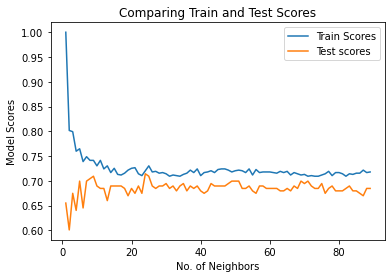

In [19]:
# Checking K-neighbors for max value
train_scores = []
test_scores = []
neighbors = range(1,90)

knn = KNeighborsClassifier()

for i in neighbors:
    knn.set_params(n_neighbors = i)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))        
    test_scores.append(knn.score(X_test, y_test))

plt.plot(neighbors, train_scores, label = "Train Scores")
plt.plot(neighbors, test_scores, label="Test scores")
plt.xlabel("No. of Neighbors")
plt.ylabel("Model Scores")
plt.title("Comparing Train and Test Scores")
plt.legend()
print(f"maximum accuracy: {max(test_scores)*100:.2f}%")

knn_roc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
print('ROC_AUC score: ', knn_roc)

## Summary For Model With Mass:
 The K-nearest neighbors classifier was the best model to predict gender with this data set. As can be seen by the graph above, the train and test curves start to diverge around the point where n_neighbors is about 80. 

# Without Mass
Let's drop the mass column as a feature and see how the model changes!

In [20]:
X_new=X.drop(["mass"],axis=1)

In [21]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_new,
                                y,test_size=0.2,
                                random_state=68)

In [22]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [23]:
# Instantiate logistic regression
logreg = LogisticRegression()

# Fit logreg to the train set
logreg.fit(X_train,y_train)

# Predict instances from the test set
y_pred = logreg.predict(X_test)

# Accuracy score of logreg model
print("Accuracy of logistic regression classifier: ", logreg.score(X_test,y_test))

# Print model score
r_sq = logreg.score(X_new, y)
print('r squared: ', r_sq)

# Confusion matrix of the logreg model
print('Confusion matrix:\n ', confusion_matrix(y_test,y_pred))

Accuracy of logistic regression classifier:  0.5172413793103449
r squared:  0.4719211822660099
Confusion matrix:
  [[27 59]
 [39 78]]


## TPOT Classifier For New Model

In [24]:
# Instantiate TPOTClassifier
tpot = TPOTClassifier(
    generations=10,
    population_size=20,
    verbosity=2,
    scoring='roc_auc',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)
tpot.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.5416738467538914

Generation 2 - Current best internal CV score: 0.5416738467538914

Generation 3 - Current best internal CV score: 0.5416738467538914

Generation 4 - Current best internal CV score: 0.5416738467538914

Generation 5 - Current best internal CV score: 0.5416738467538914

Generation 6 - Current best internal CV score: 0.5438339142862597

Generation 7 - Current best internal CV score: 0.5447989802866944

Generation 8 - Current best internal CV score: 0.5494596160437559

Generation 9 - Current best internal CV score: 0.5494596160437559

Generation 10 - Current best internal CV score: 0.5494596160437559

Best pipeline: KNeighborsClassifier(Normalizer(FeatureAgglomeration(input_matrix, affinity=cosine, linkage=average), norm=l1), n_neighbors=73, p=2, weights=distance)


TPOTClassifier(config_dict='TPOT light', disable_update_check=True,
               generations=10, population_size=20, random_state=42,
               scoring='roc_auc', verbosity=2)

In [25]:
# AUC score for tpot model
tpot_auc_score = roc_auc_score(y_test, tpot.predict_proba(X_test)[:, 1])
print(f'\nROC_AUC score: {tpot_auc_score:.4f}')


ROC_AUC score: 0.4537


## Overall Summary:
The model was clearly hurt by removing mass as a feature, as predicted. Since monk seals exhibit sexual dimorphism- the males are slightly larger than females, except for Hawaiian monk seals, where females are larger- a predictive model that includes mass would intuitively be more accurate. 